In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
import json
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import defaultdict

In [ ]:
def load_model(model_name):
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        trust_remote_code=True,
        # use_flash_attention_2=True,
    )
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    return model, tokenizer

model, tokenizer = load_model("deepseek-ai/deepseek-moe-16b-base")

In [39]:
def get_moe_metadata(model, input_ids):
    """Get both router logits and expert indices for all MoE layers"""
    router_logits_list = []
    expert_indices_list = []
    
    def hook_fn(module, input, output):
        # output contains: (topk_idx, topk_weight, aux_loss)
        hidden_states = input[0]
        
        logits = torch.matmul(hidden_states, module.weight.T)
        router_logits_list.append(logits.detach())
        
        # store expert indices actually used for routing
        expert_indices_list.append(output[0].detach())
        
        return output
    
    hooks = []
    for layer_idx, layer in enumerate(model.model.layers):
        if layer.mlp.__class__.__name__ == 'DeepseekMoE':
            hook = layer.mlp.gate.register_forward_hook(hook_fn)
            hooks.append(hook)

    with torch.no_grad():
        model(input_ids)
    
    for hook in hooks:
        hook.remove()

    moe_metadata = {
        'router_logits': torch.stack(router_logits_list) if router_logits_list else None,
        'expert_indices': torch.stack(expert_indices_list) if expert_indices_list else None
    }
    
    if moe_metadata['router_logits'] is not None:
        print(f"Router logits shape: {moe_metadata['router_logits'].shape}")
    if moe_metadata['expert_indices'] is not None:
        print(f"Expert indices shape: {moe_metadata['expert_indices'].shape}")
    
    return moe_metadata

In [ ]:
# input_txt = 'the quick brown fox'
# input_ids = tokenizer.encode(input_txt, return_tensors="pt")
# moe_metadata = get_moe_metadata(model, input_ids)
# print(moe_metadata)
# router_logits = moe_metadata['router_logits']

In [136]:
def get_last_token_router_probs(router_logits, model_layer_idx):
    """
    Get router probabilities for the last token in the sequence
    for a specific MODEL LAYER INDEX (1-27 for MoE layers)
    """
    # convert model layer index (1-27) to router_logits index (0-26)
    router_logits_idx = model_layer_idx - 1
    
    if router_logits_idx < 0 or router_logits_idx >= router_logits.size(0):
        raise ValueError(f"Invalid model_layer_idx {model_layer_idx}. Must be 1-27 for MoE layers")
    
    layer_logits = router_logits[router_logits_idx]  # [1, 5, 64]
    
    last_token_logits = layer_logits[0, -1, :]  # [64]
    routing_probs = torch.nn.functional.softmax(last_token_logits, dim=-1)
    
    return routing_probs

def topk(router_probs, k):
    """zero out all components except top k router probabilities"""
    values, indices = torch.topk(router_probs, k)
    zeroed_probs = torch.zeros_like(router_probs)
    zeroed_probs[indices] = values
    return zeroed_probs

In [73]:
def get_moe_data(model, tokenizer, prompts):
    """
    collects both all-token and last-token MoE data in a single forward pass per prompt.
    
    returns:
        all_token_logits: Tensor [num_prompts, num_layers, max_seq_len, num_experts] (padded)
        all_token_experts: Tensor [num_prompts, num_layers, max_seq_len, top_k] (padded with -1)
        last_token_logits: Tensor [num_prompts, num_layers, num_experts]
        last_token_experts: Tensor [num_prompts, num_layers, top_k]
    """
    num_prompts = len(prompts)
    max_seq_len = max(tokenizer(prompt, return_tensors="pt").input_ids.size(1) for prompt in prompts)
    num_moe_layers = sum(1 for layer in model.model.layers if layer.mlp.__class__.__name__ == 'DeepseekMoE')
    print(f"Number of MoE layers: {num_moe_layers}")
    num_experts = model.config.n_routed_experts  # 64
    top_k = model.config.num_experts_per_tok  # 6

    all_token_logits = torch.zeros((num_prompts, num_moe_layers, max_seq_len, num_experts),
                                  dtype=torch.float16)
    all_token_experts = -torch.ones((num_prompts, num_moe_layers, max_seq_len, top_k),
                                   dtype=torch.long)
    last_token_logits = torch.zeros((num_prompts, num_moe_layers, num_experts),
                                   dtype=torch.float16)
    last_token_experts = torch.zeros((num_prompts, num_moe_layers, top_k),
                                    dtype=torch.long)

    for prompt_idx, prompt in enumerate(prompts):
        input_ids = tokenizer(prompt, return_tensors="pt").input_ids
        seq_len = input_ids.size(1)
        
        with torch.no_grad():
            moe_metadata = get_moe_metadata(model, input_ids)
        
        # Process each MoE layer
        for layer_idx in range(num_moe_layers):
            # Get raw data for this layer
            layer_logits = moe_metadata['router_logits'][layer_idx].squeeze(0)  # [seq_len, 64]
            layer_experts = moe_metadata['expert_indices'][layer_idx]  # [seq_len, 6]

            # Store all tokens data (with padding)
            all_token_logits[prompt_idx, layer_idx, :seq_len] = layer_logits
            all_token_experts[prompt_idx, layer_idx, :seq_len] = layer_experts
            
            # Extract and store last token data
            last_token_logits[prompt_idx, layer_idx] = layer_logits[seq_len-1]
            last_token_experts[prompt_idx, layer_idx] = layer_experts[seq_len-1]

    return all_token_logits, all_token_experts, last_token_logits, last_token_experts

In [74]:
# test_prompts = ['the quick brown fox', 'the capital of japan is tokyo', '12*2 is 24']
# all_token_logits, all_token_experts, last_token_logits, last_token_experts = get_moe_data(model, tokenizer, prompts= test_prompts)

Number of MoE layers: 27


Router logits shape: torch.Size([27, 1, 5, 64])
Expert indices shape: torch.Size([27, 5, 6])
Router logits shape: torch.Size([27, 1, 10, 64])
Expert indices shape: torch.Size([27, 10, 6])
Router logits shape: torch.Size([27, 1, 9, 64])
Expert indices shape: torch.Size([27, 9, 6])


In [137]:
def prepare_prompts_from_txt(txt_file_path,  domain = 'english', output_path=f'english.json'):
    """ read prompts from a txt file and save them in json format. """
    
    with open(txt_file_path, 'r', encoding='utf-8') as f:
        prompts = [line.strip() for line in f.readlines() if line.strip()]
    
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump({f"{domain}": prompts}, f, indent=4)
        
    print(f"{domain} prompts saved to {output_path}")
    return prompts

def parse_code_blocks(txt_file_path, output_path='code.json', domain='code'):
    """parse code blocks between ``` markers from a text file and save them in json format."""
    code_blocks = []
    current_block = []
    in_block = False
    
    with open(txt_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            if line.strip().startswith('```'):
                if in_block:
                    # Current block is complete, save it and start new block
                    if current_block:
                        code_blocks.append('\n'.join(current_block))
                    current_block = []
                # Always start a new block since ``` only indicates start
                in_block = True
                current_block = []
            elif in_block:
                # Add line to current block
                current_block.append(line.rstrip())
    
    # Save final block if exists
    if current_block:
        code_blocks.append('\n'.join(current_block))
    
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump({domain: code_blocks}, f, indent=4)
        
    print(f"code blocks saved to {output_path}")
    return code_blocks

In [138]:
def load_prompts_from_json(json_file_path):
    """load prompts from a json file and return them as a list."""
    with open(json_file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    # get the first (and only) value from the dictionary
    # since the json structure is {"domain": [prompts]}
    prompts = list(data.values())[0]
    return prompts

def prepare_multi_domain_prompts(domain_files, output_path='all_domain_prompts.json'):
    """
    prepare a json file containing prompts from multiple domains.
    
    args:
        domain_files: Dict mapping domain names to lists of tuples (file_path, parser_func)
            where parser_func is a function that takes a file path and returns a list of prompts
            
    example:
        domain_files = {
            'code': [('code.txt', parse_code_blocks)], 
            'english': [('english.txt', prepare_prompts_from_txt)]
        }
    """
    all_prompts = {}
    
    for domain, file_list in domain_files.items():
        domain_prompts = []
        for _, prompts in file_list:
            # Use load_prompts_from_json if prompts is a dict
            if not isinstance(prompts, list):
                prompts = load_prompts_from_json(prompts)
            domain_prompts.extend(prompts)
                
        all_prompts[domain] = domain_prompts
        
    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(all_prompts, f, indent=4)
        
    print(f"all domain prompts saved to {output_path}")
    return all_prompts

def convert_all_to_list(all_prompts):
    """
    combines prompts from all domains into a single list of domain-specific prompt lists.
    returns a list in the format [[domain1_prompts], [domain2_prompts], ...].
    """
    # Create list of domain-specific prompt lists
    combined_prompts = [
        prompts for prompts in all_prompts.values()
    ]
        
    total_prompts = sum(len(prompts) for prompts in combined_prompts)
    print(f"total prompts: {total_prompts}")
    print(f"prompts per domain:")
    for domain, prompts in zip(all_prompts.keys(), combined_prompts):
        print(f"  {domain}: {len(prompts)}")
        
    return combined_prompts

In [ ]:
prepare_prompts_from_txt('interp-data/engl-lit.txt', domain='english', output_path='english.json')
prepare_prompts_from_txt('interp-data/french.txt', domain='french', output_path='french.json')
parse_code_blocks('interp-data/code.txt', 'code.json', domain='code')

code_prompts = load_prompts_from_json(json_file_path='code.json')
print(f"total code prompts : {len(code_prompts)}")
english_prompts = load_prompts_from_json(json_file_path='english.json')
print(f'total english prompts : {len(english_prompts)}')


domain_files = {
    'code': [('interp-data/code.txt', parse_code_blocks(txt_file_path='interp-data/code.txt', output_path='code.json', domain='code'))],
    'english': [('interp-data/engl-lit.txt', prepare_prompts_from_txt(txt_file_path='interp-data/engl-lit.txt', output_path='english.json', domain='english'))],
    'french': [('interp-data/french.txt', prepare_prompts_from_txt(txt_file_path='interp-data/french.txt', output_path='french.json', domain='french'))]
}
all_prompts = prepare_multi_domain_prompts(domain_files, output_path='all_prompts.json')
print(f"total domains : {len(all_prompts)}")

# convert all prompts to a single list of domain-specific prompt lists
combined_prompts = convert_all_to_list(all_prompts)

In [ ]:
all_token_logits, all_token_experts, last_token_logits, last_token_experts = get_moe_data(model, tokenizer, prompts= combined_prompts)

In [ ]:
torch.save(all_token_logits, "all_token_logits.pt")
torch.save(all_token_experts, "all_token_experts.pt")
torch.save(last_token_logits, "last_token_logits.pt")
torch.save(last_token_experts, "last_token_experts.pt")

In [5]:
all_token_logits = torch.load("interp-pt/all_token_logits.pt", map_location=torch.device('cpu'), weights_only=True)
all_token_experts = torch.load("interp-pt/all_token_experts.pt", map_location=torch.device('cpu'), weights_only=True)
last_token_logits = torch.load("interp-pt/last_token_logits.pt", map_location=torch.device('cpu'), weights_only=True)
last_token_experts = torch.load("interp-pt/last_token_experts.pt", map_location=torch.device('cpu'), weights_only=True)

In [6]:
print(f'all_token_logits shape: {all_token_logits.shape}')
print(f'all_token_experts shape: {all_token_experts.shape}')
print(f'last_token_logits shape: {last_token_logits.shape}')
print(f'last_token_experts shape: {last_token_experts.shape}')

all_token_logits shape: torch.Size([600, 27, 284, 64])
all_token_experts shape: torch.Size([600, 27, 284, 6])
last_token_logits shape: torch.Size([600, 27, 64])
last_token_experts shape: torch.Size([600, 27, 6])


In [93]:
def bar_graph_visualize(last_token_experts, layer_number, domain, k=6):
    # Determine domain slice (200 prompts)
    if domain == 'code':
        domain_slice = slice(0, 200)
    elif domain == 'english':
        domain_slice = slice(200, 400)
    elif domain == 'french':
        domain_slice = slice(400, 600)
    else:
        raise ValueError("Domain must be 'code', 'english', or 'french'.")
    
    # Validate layer number
    layer_idx = layer_number - 1
    if layer_idx < 0 or layer_idx >= last_token_experts.size(1):
        raise ValueError("Layer number must be between 1 and 27.")
    
    # Extract expert indices for the domain and layer [200 prompts, 6 experts]
    domain_experts = last_token_experts[domain_slice, layer_idx, :].numpy()  # shape: [200, 6]
    
    # For each expert, count how many tokens include it in their top-k
    expert_counts = np.zeros(64, dtype=int)
    for token_experts in domain_experts:
        unique_experts = np.unique(token_experts)  # Avoid double-counting duplicates
        for expert in unique_experts:
            expert_counts[expert] += 1
    
    # Compute percentages
    total_tokens = domain_experts.shape[0]  # N_D = 200
    percentages = (expert_counts / total_tokens) * 100
    
    # Plot
    plt.figure(figsize=(15, 6))
    bars = plt.bar(range(64), percentages, color='skyblue')
    plt.xlabel('expert ID')
    plt.ylabel(f'% of Tokens in {domain.capitalize()} Domain Selecting Expert (Top-{k})')
    plt.title(f'domain specialization at layer {layer_number} for {domain} domain')
    plt.xticks(np.arange(0, 64, 4))
    plt.ylim(0, 100)  # Set fixed y-axis limits from 0 to 100
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Highlight non-zero bars
    for bar in bars:
        if bar.get_height() > 0:
            bar.set_color('steelblue')
    
    plt.show()

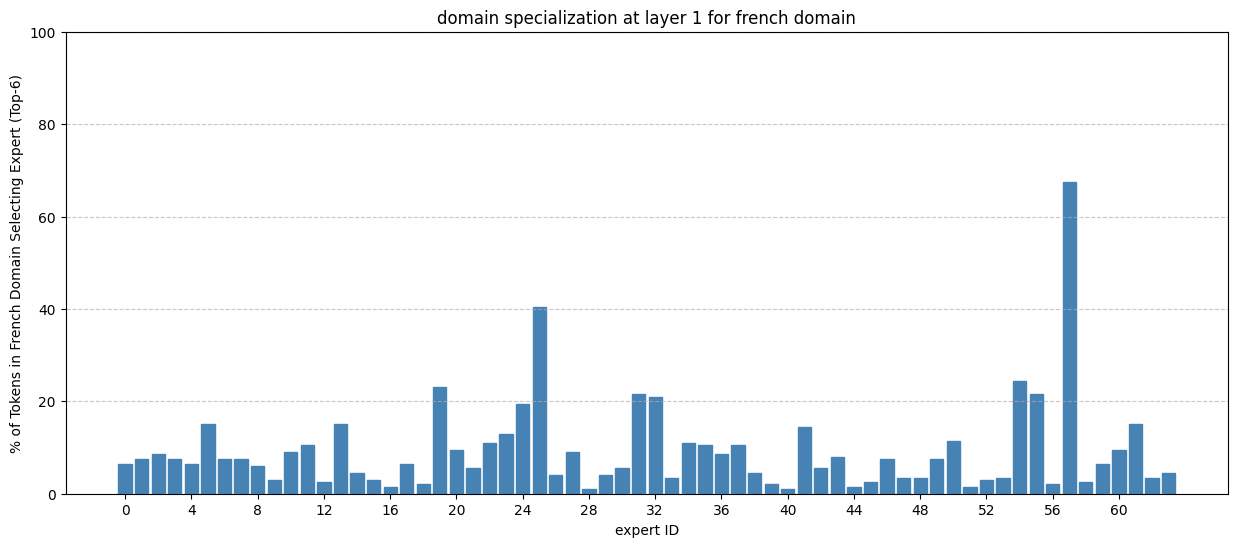

In [94]:
bar_graph_visualize(last_token_experts, layer_number=1, domain='french')

total tokens : 200


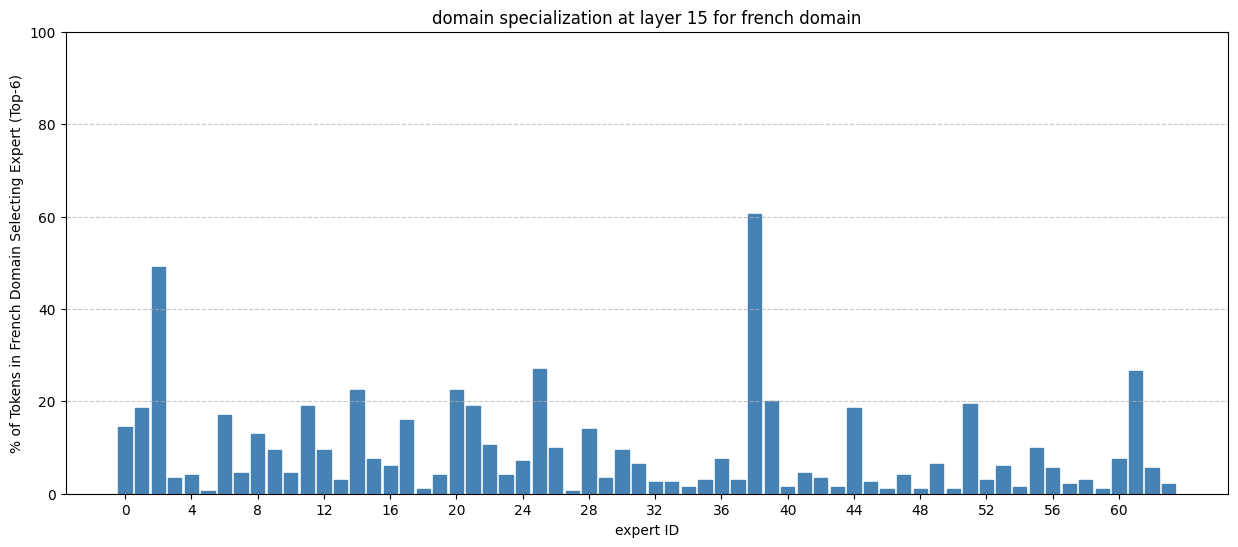

In [71]:
bar_graph_visualize(last_token_experts, layer_number=15, domain='french')

total tokens : 200


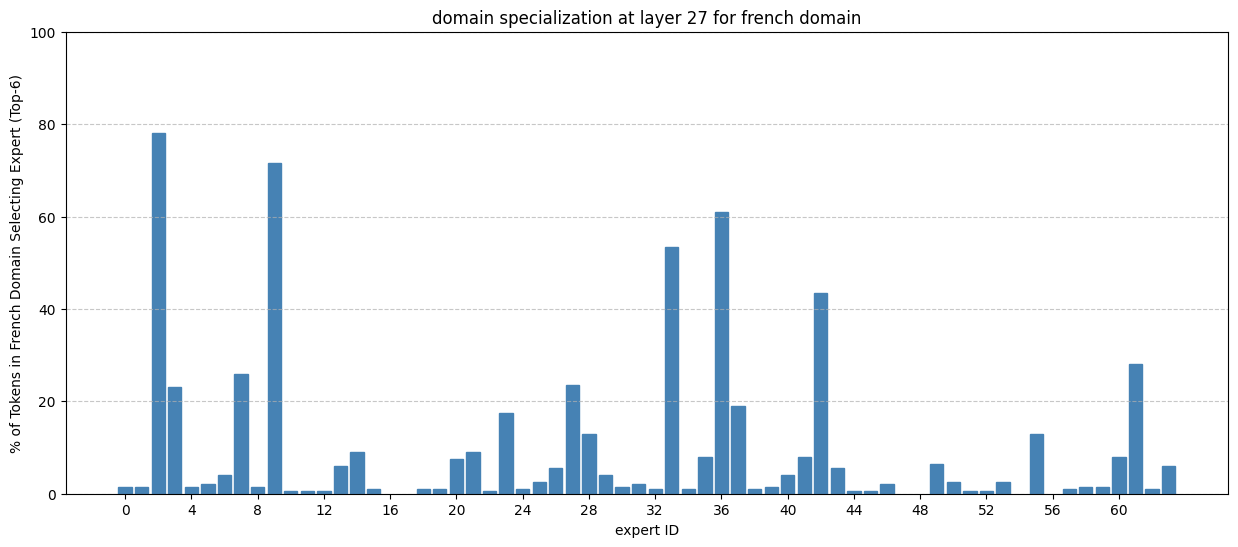

In [74]:
bar_graph_visualize(last_token_experts, layer_number=27, domain='french')

In [102]:
def stacked_bar_graph(last_token_experts, layer_number):
    """
    Args:
        last_token_experts: Tensor of shape [600, 27, 6] (prompts, layers, experts)
        layer_number: Layer to analyze (1-27)
    """
    # Validate layer
    layer_idx = layer_number - 1
    if layer_idx < 0 or layer_idx >= last_token_experts.size(1):
        raise ValueError("Layer number must be between 1 and 27.")
    
    # Extract data for the specified layer [600 prompts, 6 experts]
    layer_data = last_token_experts[:, layer_idx, :].numpy()
    
    # Split into domains
    code = layer_data[:200]    # First 200 prompts (code)
    english = layer_data[200:400]  # Next 200 (english)
    french = layer_data[400:600]   # Last 200 (french)
    
    # Initialize domain-specific expert counts
    code_counts = np.zeros(64, dtype=int)
    eng_counts = np.zeros(64, dtype=int)
    fr_counts = np.zeros(64, dtype=int)
    
    # Count occurrences for each domain (unique experts per token)
    for domain_data, counts in zip([code, english, french], [code_counts, eng_counts, fr_counts]):
        for token_experts in domain_data:
            unique_experts = np.unique(token_experts)
            for expert in unique_experts:
                counts[expert] += 1
    
    # Convert counts to percentages (relative to N_D=600)
    total_tokens = 600
    code_pct = (code_counts / total_tokens) * 100
    eng_pct = (eng_counts / total_tokens) * 100
    fr_pct = (fr_counts / total_tokens) * 100
    
    # Plot settings
    experts = np.arange(64)
    colors = ['#2c7bb6', '#d7191c', '#fdae61']  # Colorblind-friendly : blue, red, orange
    labels = ['Code', 'English', 'French']
    
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.bar(experts, code_pct, color=colors[0], label=labels[0])
    ax.bar(experts, eng_pct, bottom=code_pct, color=colors[1], label=labels[1])
    ax.bar(experts, fr_pct, bottom=code_pct+eng_pct, color=colors[2], label=labels[2])
    
    ax.set_xlabel('expert ID', fontsize=12)
    ax.set_ylabel('percentage of total tokens', fontsize=12)
    ax.set_title(f'domain contributions to experts (layer {layer_number})', fontsize=14)
    ax.set_xticks(np.arange(0, 64, 4))
    ax.legend(loc='upper right')
    plt.show()

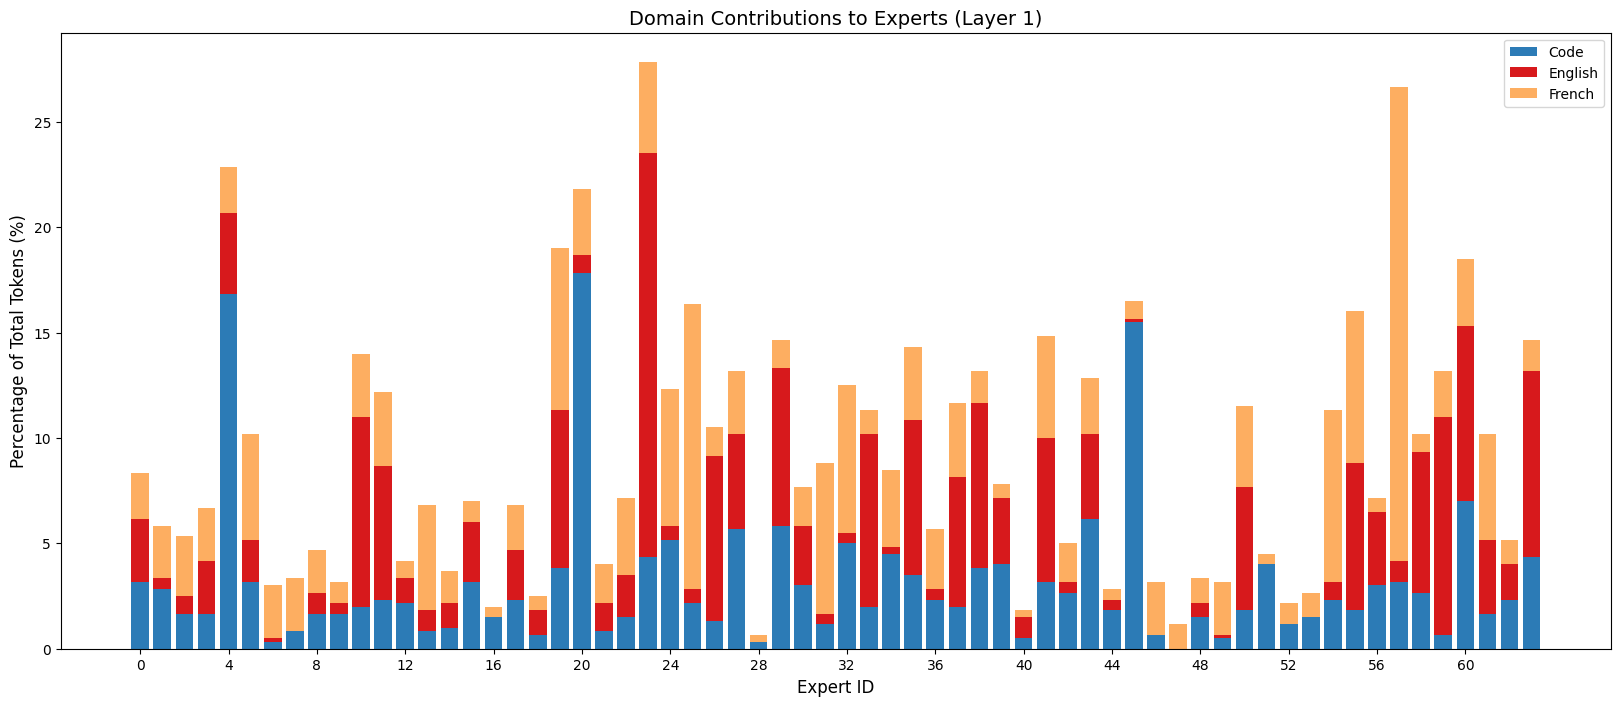

In [103]:
stacked_bar_graph(last_token_experts, layer_number=1)

In [114]:
def bar_graph_all_tokens(all_token_experts, layer_number, domain):
    """
    Visualizes expert distribution for all tokens in a domain and layer.
    
    Args:
        all_token_experts: Tensor of shape [600, 27, 284, 6] (prompts, layers, tokens, experts)
        layer_number: Layer to analyze (1-27)
        domain: 'code', 'english', or 'french'
    """
    # Validate domain and extract slice
    if domain == 'code':
        domain_slice = slice(0, 200)
    elif domain == 'english':
        domain_slice = slice(200, 400)
    elif domain == 'french':
        domain_slice = slice(400, 600)
    else:
        raise ValueError("Domain must be 'code', 'english', or 'french'.")
    
    # Validate layer index
    layer_idx = layer_number - 1
    if layer_idx < 0 or layer_idx >= all_token_experts.size(1):
        raise ValueError("Layer number must be between 1 and 27.")
    
    # Extract data for domain and layer [200 prompts, 284 tokens, 6 experts]
    domain_data = all_token_experts[domain_slice, layer_idx, :, :].numpy()
    # Flatten and filter out padding (experts = -1)
    flattened = domain_data.reshape(-1, 6)  # [200*284, 6]
    valid_tokens_mask = (flattened[:, 0] != -1)  # Padding uses -1
    valid_experts = flattened[valid_tokens_mask]
    # Count unique experts per token
    expert_counts = np.zeros(64, dtype=int)
    for token_experts in valid_experts:
        unique_experts = np.unique(token_experts)
        for expert in unique_experts:
            expert_counts[expert] += 1
    
    # Compute percentages
    total_valid_tokens = valid_experts.shape[0]
    print(f'total valid tokens : {total_valid_tokens}')
    percentages = (expert_counts / total_valid_tokens) * 100
    
    # Plot
    plt.figure(figsize=(15, 6))
    bars = plt.bar(range(64), percentages, color='steelblue')
    plt.xlabel('expert ID', fontsize=12)
    plt.ylabel('% of total tokens selecting expert', fontsize=12)
    plt.title(f'expert selection for {domain.capitalize()} domain (layer {layer_number}) - all tokens', fontsize=14)
    plt.xticks(np.arange(0, 64, 4))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Highlight bars with non-zero values
    for bar in bars:
        if bar.get_height() > 0:
            bar.set_color('#2c7bb6')  # Darker blue for emphasis
    
    plt.show()

domain data shape : (200, 284, 6)
valid experts : (5428, 6)
total valid tokens : 5428


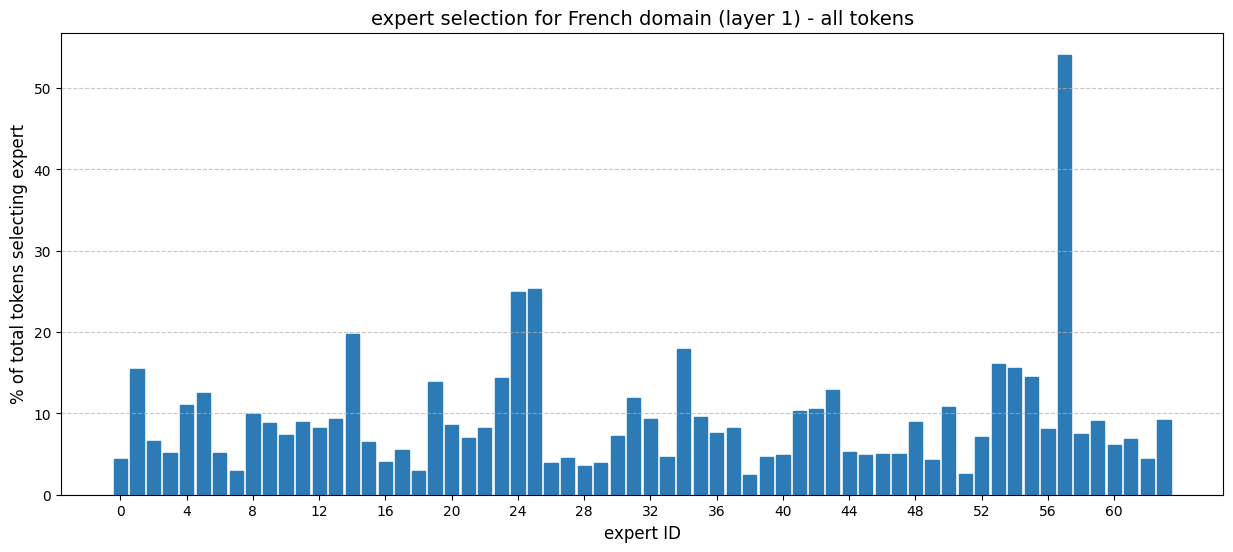

In [120]:
bar_graph_all_tokens(all_token_experts, layer_number=1, domain='french')

In [157]:
def stacked_bar_graph_all_tokens(all_token_experts, layer_number):
    """
    Visualizes domain contributions to experts across ALL tokens (non-padded) for a given layer.
    Normalizes counts per domain to balance influence.
    """
    # Validate layer
    layer_idx = layer_number - 1
    if layer_idx < 0 or layer_idx >= all_token_experts.size(1):
        raise ValueError("Layer number must be between 1 and 27.")
    
    # Extract layer data [600 prompts, 284 tokens, 6 experts]
    layer_data = all_token_experts[:, layer_idx, :, :].numpy()
    
    # Split into domains
    code = layer_data[:200]    # Code domain (prompts 0-199)
    english = layer_data[200:400]  # English (prompts 200-399)
    french = layer_data[400:600]   # French (prompts 400-599)
    
    def process_domain(domain_data):
        """Process a domain's data to count valid tokens and expert usage."""
        flattened = domain_data.reshape(-1, 6)
        valid_mask = flattened[:, 0] != -1
        valid_experts = flattened[valid_mask]
        counts = np.zeros(64, dtype=int)
        for token in valid_experts:
            unique_experts = np.unique(token)
            for expert in unique_experts:
                counts[expert] += 1
        return counts, valid_experts.shape[0]
    
    # Process domains and get raw counts/tokens
    code_counts, code_valid = process_domain(code)
    eng_counts, eng_valid = process_domain(english)
    fr_counts, fr_valid = process_domain(french)
    
    # Normalize counts to balance domain contributions
    def normalize_counts(counts, domain_valid_tokens, scaling_factor=1000):
        """Scale counts to a common token count (e.g., 1000 tokens per domain)."""
        scale = scaling_factor / domain_valid_tokens
        return (counts * scale).astype(int)
    
    # Choose a scaling factor (e.g., min token count or fixed value)
    scaling_factor = min(code_valid, eng_valid, fr_valid)  # Use smallest domain size
    print(f'scaling factor : {scaling_factor}')
    
    # Normalize counts
    code_norm = normalize_counts(code_counts, code_valid, scaling_factor)
    eng_norm = normalize_counts(eng_counts, eng_valid, scaling_factor)
    fr_norm = normalize_counts(fr_counts, fr_valid, scaling_factor)
    
    # Total tokens after normalization (scaling_factor * 3 for 3 domains)
    total_normalized_tokens = scaling_factor * 3
    print(f'total normalized tokens : {total_normalized_tokens}')
    # Compute percentages
    code_pct = (code_norm / total_normalized_tokens) * 100
    eng_pct = (eng_norm / total_normalized_tokens) * 100
    fr_pct = (fr_norm / total_normalized_tokens) * 100
    
    # Plot settings
    experts = np.arange(64)
    colors = ['#2c7bb6', '#d7191c', '#fdae61']
    labels = ['Code', 'English', 'French']
    
    fig, ax = plt.subplots(figsize=(20, 8))
    ax.bar(experts, code_pct, color=colors[0], label=labels[0])
    ax.bar(experts, eng_pct, bottom=code_pct, color=colors[1], label=labels[1])
    ax.bar(experts, fr_pct, bottom=code_pct+eng_pct, color=colors[2], label=labels[2])
    
    ax.set_xlabel('Expert ID', fontsize=12)
    ax.set_ylabel('Percentage of Normalized Tokens (%)', fontsize=12)
    ax.set_title(f'Balanced Domain Contributions to Experts (Layer {layer_number})', fontsize=14)
    ax.set_xticks(np.arange(0, 64, 4))
    ax.legend(loc='upper right')
    plt.show()

 valid experts shape : (14712, 6)
 valid experts shape : (4156, 6)
 valid experts shape : (5428, 6)
scaling factor : 4156
total normalized tokens : 12468


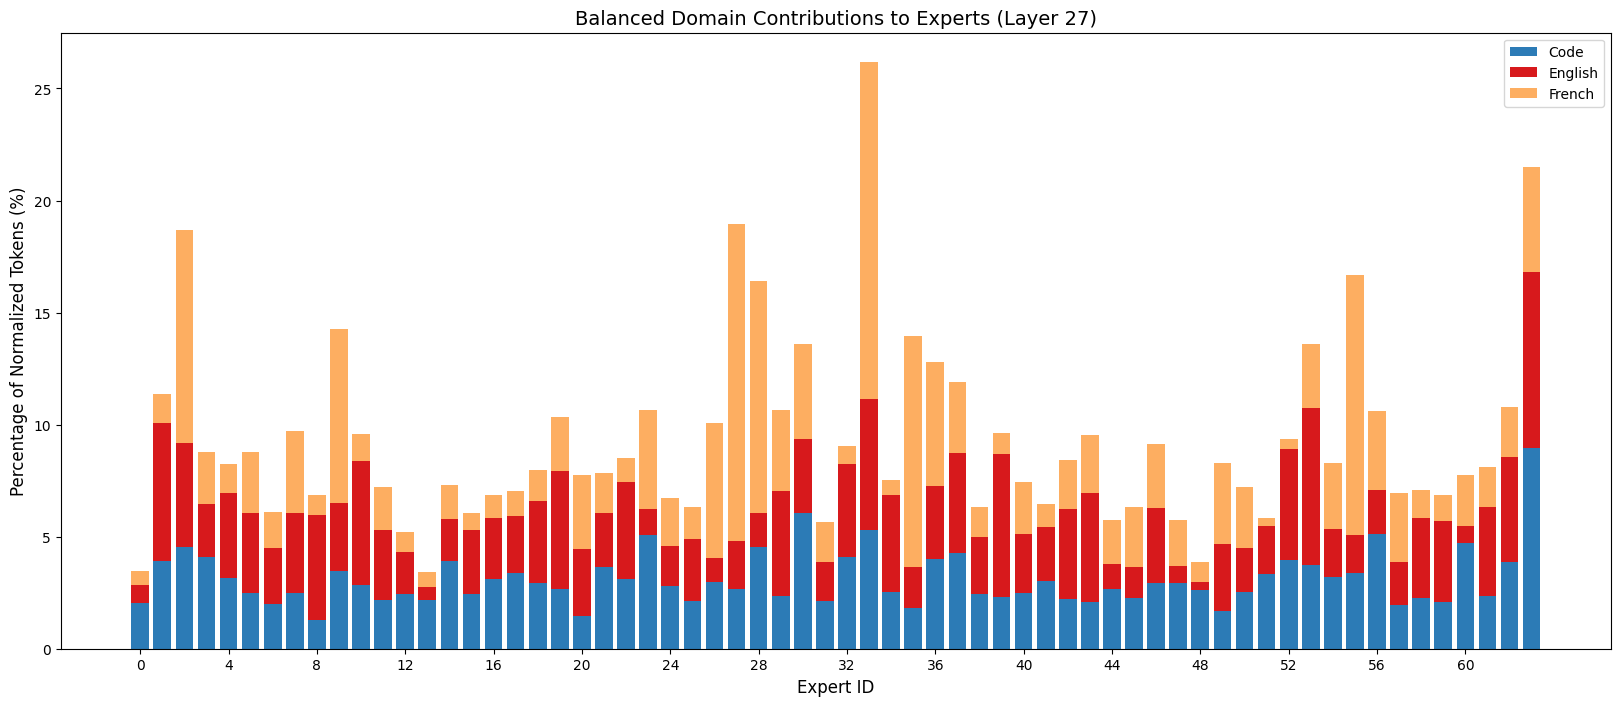

In [158]:
stacked_bar_graph_all_tokens(all_token_experts, layer_number=27)

In [171]:
def expert_coactivation(last_token_experts, layer_number, top_k=64):
    """
    Visualizes expert co-activation for a specified layer using last token experts.
    
    Args:
        last_token_experts: Tensor of shape [600, 27, 6] (prompts, layers, top_k=6).
        layer_number: Layer to analyze (1-27).
        top_k: Number of top experts to display based on maximum co-activation scores.
    """
    # Validate layer index
    layer_idx = layer_number - 1
    if layer_idx < 0 or layer_idx >= last_token_experts.size(1):
        raise ValueError("Layer number must be between 1 and 27.")
    
    # Extract data for the specified layer [600 prompts, 6 experts]
    layer_data = last_token_experts[:, layer_idx, :].numpy()
    
    # Initialize co-occurrence and expert activation counts
    co_occurrence = np.zeros((64, 64), dtype=int)
    expert_activations = np.zeros(64, dtype=int)
    
    # Process each token's expert selections
    for token_experts in layer_data:
        unique_experts = np.unique(token_experts)  # Remove duplicates
        # Update expert activation counts
        for expert in unique_experts:
            expert_activations[expert] += 1
        # Update co-occurrence matrix
        for i in unique_experts:
            for j in unique_experts:
                if i != j:
                    co_occurrence[i, j] += 1
    
    # Compute co-activation matrix (directed)
    co_activation = np.zeros((64, 64))
    for i in range(64):
        if expert_activations[i] > 0:
            co_activation[i, :] = (co_occurrence[i, :] / expert_activations[i]) * 100
    
    # Identify top-k experts with highest max co-activation scores
    max_scores = np.max(co_activation, axis=1)
    top_experts = np.argsort(-max_scores)[:top_k]
    top_experts = np.sort(top_experts)  # Sort for ordered display
    
    # Filter matrix to include only top experts
    filtered_matrix = co_activation[np.ix_(top_experts, top_experts)]
    
    # Plot settings
    plt.figure(figsize=(12, 10))
    plt.imshow(filtered_matrix, cmap="viridis", interpolation="nearest", aspect="auto")
    plt.colorbar(label="Co-activation (%)", shrink=0.8)
    
    # Label axes with expert IDs
    tick_labels = [f"E{expert}" for expert in top_experts]
    plt.xticks(np.arange(len(top_experts)), tick_labels, rotation=90)
    plt.yticks(np.arange(len(top_experts)), tick_labels)
    plt.xlabel("Expert $E_j$")
    plt.ylabel("Expert $E_i$")
    plt.title(f"Expert Co-activation (Layer {layer_number}) - Top {top_k} Experts")
    plt.tight_layout()
    plt.show()

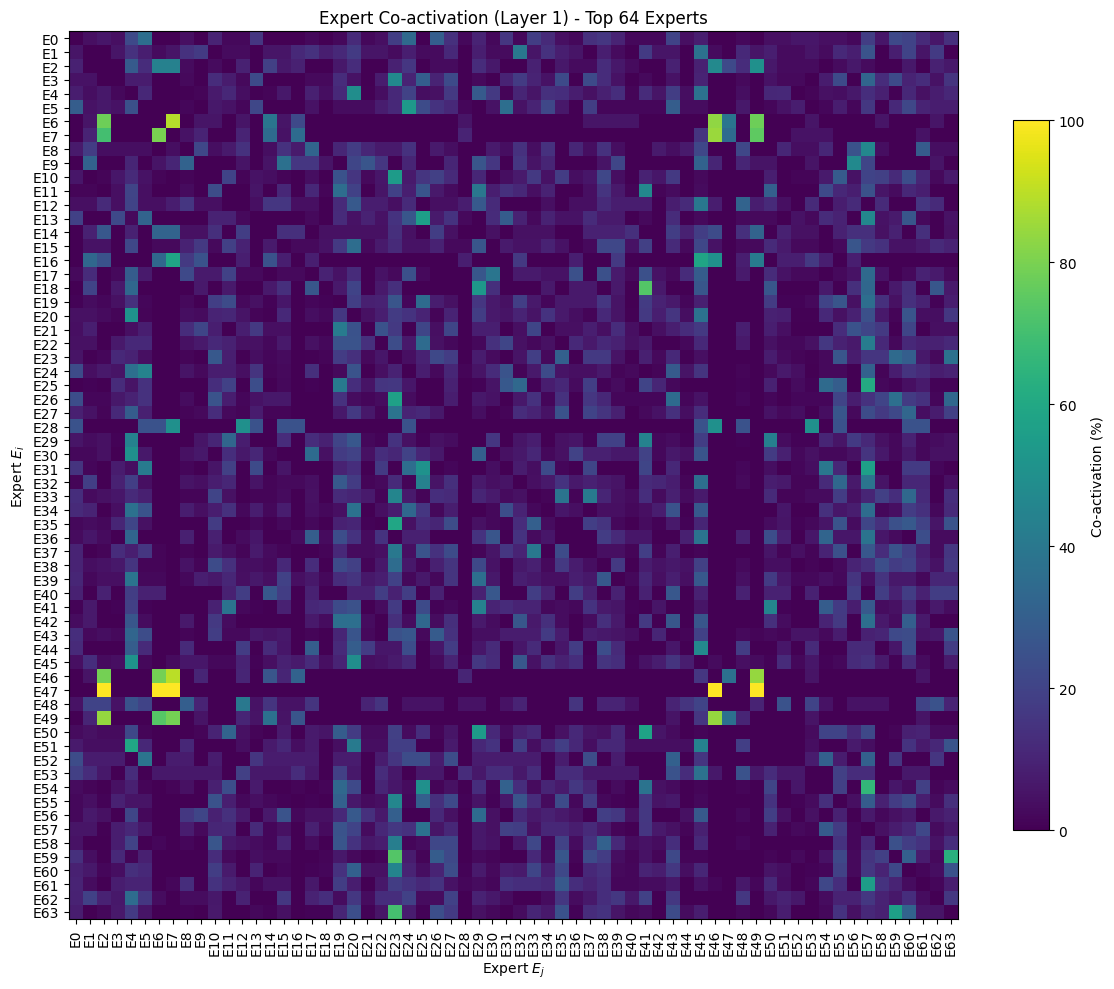

In [178]:
expert_coactivation(last_token_experts, layer_number=1)